In [1]:
using Clustering
using CSV
using Compose, Cairo, Fontconfig
using DataFrames
using DataFramesMeta
using Dates
using Distances
using Distributions
using HypothesisTests
using Plots
using Statistics
using StatsBase
using StatsPlots

[ Info: Precompiling AccessorsStaticArraysExt [91548973-bbcf-5128-ac3c-c8b871e934a5]
[ Info: Precompiling AccessorsUnitfulExt [0f33c9ce-b40b-5f58-839e-64dee873ac84]


In [26]:
folder = joinpath(@__DIR__(), "data")
vic_trips = CSV.read(joinpath(folder, "Victoria-GTFS\\trips.txt"), DataFrames.DataFrame)
nanaimo = CSV.read(joinpath(folder, "nanaimo_ridership_fall_2023.csv"), DataFrames.DataFrame)
victoria = CSV.read(joinpath(folder, "victoria_ridership_fall_2023.csv"), DataFrames.DataFrame);

In [25]:
nanaimo.direction = [(d in ["Inbound", "North", "Clockwise", "East"] ? false : true) for d in nanaimo.direction]
victoria.direction = [(d in ["Inbound", "North", "Clockwise", "East"] ? false : true) for d in victoria.direction];

In [27]:
holidays = [
    Date(2023, 9, 4), # labour day
    Date(2023, 9, 30), # truth and reconciliation
    Date(2023, 10, 9), # thanksgiving
    Date(2023, 11, 11), # remembrance day
]

nanaimo.is_holiday = [date in holidays for date in nanaimo.date]
victoria.is_holiday = [date in holidays for date in victoria.date];

In [28]:
nanaimo.is_weekday = Dates.dayofweek.(nanaimo.date) .< 5
victoria.date = Dates.Date.(victoria.date, dateformat"m/d/y")
victoria.is_weekday = Dates.dayofweek.(victoria.date) .< 5;

In [29]:
nanaimo.primary_delay_seconds = nanaimo.end_delay_seconds - nanaimo.start_delay_seconds
victoria.primary_delay_seconds = victoria.end_delay_seconds - victoria.start_delay_seconds;

In [30]:
nanaimo.primary_delay_pct = nanaimo.primary_delay_seconds ./ nanaimo.planned_duration_seconds
victoria.primary_delay_pct = victoria.primary_delay_seconds ./ victoria.planned_duration_seconds;

In [31]:
nanaimo.trip_long = nanaimo.planned_duration_seconds ./ 60 .> 40
victoria.trip_long = victoria.planned_duration_seconds ./ 60 .> 40;

In [32]:
nanaimo.planned_start_hour = Dates.hour.(nanaimo.planned_start_time)
victoria.planned_start_hour = Dates.hour.(victoria.planned_start_time);
nanaimo[nanaimo.planned_start_hour .== 0, :planned_start_hour] .= 24;
victoria[victoria.planned_start_hour .== 0, :planned_start_hour] .= 24;

In [33]:
nanaimo.passenger_delay_seconds = nanaimo.end_delay_seconds .* nanaimo.total_boardings
victoria.passenger_delay_seconds = victoria.end_delay_seconds .* victoria.total_boardings;

In [34]:
nanaimo_wkdy = nanaimo[.!nanaimo.is_holiday .& nanaimo.is_weekday, :];
victoria_wkdy = victoria[.!victoria.is_holiday .& victoria.is_weekday, :];

In [92]:
@show mean(victoria_wkdy.primary_delay_seconds) / 60
@show mean(victoria_wkdy.start_delay_seconds) / 60
@show std(victoria_wkdy.primary_delay_seconds) / 60
@show std(victoria_wkdy.start_delay_seconds) / 60
@show quantile(victoria_wkdy.primary_delay_seconds, [0.05, 0.25, 0.5, 0.75, 0.95]) ./ 60
@show quantile(victoria_wkdy.start_delay_seconds, [0.05, 0.25, 0.5, 0.75, 0.95]) ./ 60;

mean(victoria_wkdy.primary_delay_seconds) / 60 = 1.118025266161232
mean(victoria_wkdy.start_delay_seconds) / 60 = 1.0570819367008546
std(victoria_wkdy.primary_delay_seconds) / 60 = 4.110649015333647
std(victoria_wkdy.start_delay_seconds) / 60 = 2.471651931490535
quantile(victoria_wkdy.primary_delay_seconds, [0.05, 0.25, 0.5, 0.75, 0.95]) ./ 60 = [-4.25, -1.3833333333333333, 0.6333333333333333, 3.0, 8.066666666666666]
quantile(victoria_wkdy.start_delay_seconds, [0.05, 0.25, 0.5, 0.75, 0.95]) ./ 60 = [-1.1333333333333333, 0.05, 0.43333333333333335, 1.5666666666666667, 5.133333333333334]


In [36]:
victoria_wkdy.route_dir = string.(victoria_wkdy.route, ":", victoria_wkdy.direction)
route_time_direction_df = DataFrames.groupby(victoria_wkdy, [:route_dir, :planned_start_hour]);
# route_time_direction_df = DataFrames.groupby(victoria_wkdy, [:route, :planned_start_hour]);
# class_time_df = DataFrames.groupby(weekday_df, [:route_class, :planned_start_hour]);
# class_time_direction_df = DataFrames.groupby(weekday_df, [:route_class, :planned_start_hour, :direction]);
# time_direction_df = DataFrames.groupby(weekday_df, [:planned_start_hour, :direction]);

In [37]:
combined_df = combine(
    route_time_direction_df,
    :total_boardings => mean => :ridership_μ,
    :total_boardings => std => :ridership_σ,
    :primary_delay_seconds => mean => :primary_μ,
    :start_delay_seconds => mean => :secondary_μ,
    :primary_delay_seconds => std => :primary_σ,
    :start_delay_seconds => std => :secondary_σ
)
# cor_df = unstack(combined_df, [:planned_start_hour, :direction], :route, :primary_μ);
cor_df = unstack(combined_df, :planned_start_hour, :route_dir, :primary_μ);

In [38]:
first(cor_df, 5)

5×100 DataFrame
 Row │ planned_start_hour  1:West    1:East        2:West    2:East    3:Clock ⋯
     │ Int64               Float64?  Float64?      Float64?  Float64?  Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │                  6   36.5208  missing        142.031   79.3721      18. ⋯
   2 │                  7   51.3333      208.762    174.585   20.037       80.
   3 │                  8   38.8222  missing        209.579   38.563      120.
   4 │                 15   18.5435      146.304    286.848   20.3452     190.
   5 │                 16  128.587        80.1042   162.962  177.964       92. ⋯
                                                              95 columns omitted

In [39]:
# cor_mat = Matrix(cor_df[:, Not(:planned_start_hour, :direction)])
cor_mat = Matrix(cor_df[:, Not(:planned_start_hour)])

# Function to compute correlation between two columns, skipping missing values
function safe_cor(x, y)
    mask = .!(ismissing.(x) .| ismissing.(y))
    if sum(mask) < 2
        return 0
    end
    return Statistics.cor(x[mask], y[mask])
end

# Compute the correlation matrix manually
n = size(cor_mat, 2)
corr_matrix = Array{Float64}(undef, n, n)
for i in 1:n
    for j in 1:n
        corr_matrix[i, j] = safe_cor(cor_mat[:, i], cor_mat[:, j])
    end
end
setindex!.(Ref(corr_matrix), 0.0, 1:n, 1:n);

In [40]:
# Use Euclidean distance or another distance metric
dist_matrix = pairwise(Euclidean(), corr_matrix)

# Perform hierarchical clustering using the Ward method
hclust_result = hclust(dist_matrix, linkage=:ward)

# Get the order of clustering to reorder the rows/columns
cluster_order = hclust_result.order

# Reorder the correlation matrix according to the cluster order
reordered_corr_matrix = corr_matrix[cluster_order, cluster_order];

In [41]:
n_clusters = 10
clusters = cutree(hclust_result; k=n_clusters)
cluster_indices = []

for i in 1:n_clusters
    indices = findall(x -> x == i, clusters)
    sorted_indices = sort(indices, by=x -> findfirst(isequal(x), cluster_order))
    # println("Cluster $i: ", names(cor_df[:, Not(:planned_start_hour, :direction)])[sorted_indices])
    println("Cluster $i: ", names(cor_df[:, Not(:planned_start_hour)])[sorted_indices])
    push!(cluster_indices, sorted_indices)
end

Cluster 1: ["7:Clockwise", "95:East", "21:Clockwise", "24:East", "11:East", "83:North", "51:West", "81:North", "63:West", "87:South", "22:North", "95:West", "46:West", "53:West", "88:North", "27:North", "14:East", "28:North", "82:North", "8:East", "46:East", "1:West", "71:North"]
Cluster 2: ["1:East", "70:North", "8:West", "81:South", "55:Counterclockwise", "87:North", "83:South", "54:Clockwise", "32:South", "65:West", "65:East", "17:West", "17:East"]
Cluster 3: ["39:East", "53:East", "7:Counterclockwise", "2:West", "60:Clockwise", "64:East", "58:Outbound", "59:Counterclockwise", "32:North", "35:Clockwise", "31:South", "30:South", "61:West", "43:Clockwise", "64:West"]
Cluster 4: ["14:West", "4:East", "6:South", "4:West", "6:North", "70:South", "2:East", "26:West"]
Cluster 5: ["52:East", "30:North", "15:West", "56:South", "3:Counterclockwise", "75:South", "21:Counterclockwise", "52:West", "3:Clockwise", "10:Counterclockwise", "85:Clockwise", "11:West", "27:South", "72:South", "24:West",

In [51]:
names(cor_df[:, Not(:planned_start_hour)])[sortperm(vec(corr_matrix[names(cor_df[:, Not(:planned_start_hour)]) .== "5:East", :]))]

99-element Vector{String}:
 "9:East"
 "47:East"
 "48:East"
 "87:North"
 "59:Counterclockwise"
 "24:East"
 "1:East"
 "55:Counterclockwise"
 "35:Clockwise"
 "46:East"
 "83:South"
 "15:West"
 "70:South"
 ⋮
 "22:South"
 "39:West"
 "88:North"
 "72:North"
 "64:West"
 "51:East"
 "9:West"
 "47:West"
 "48:West"
 "71:South"
 "82:North"
 "82:South"

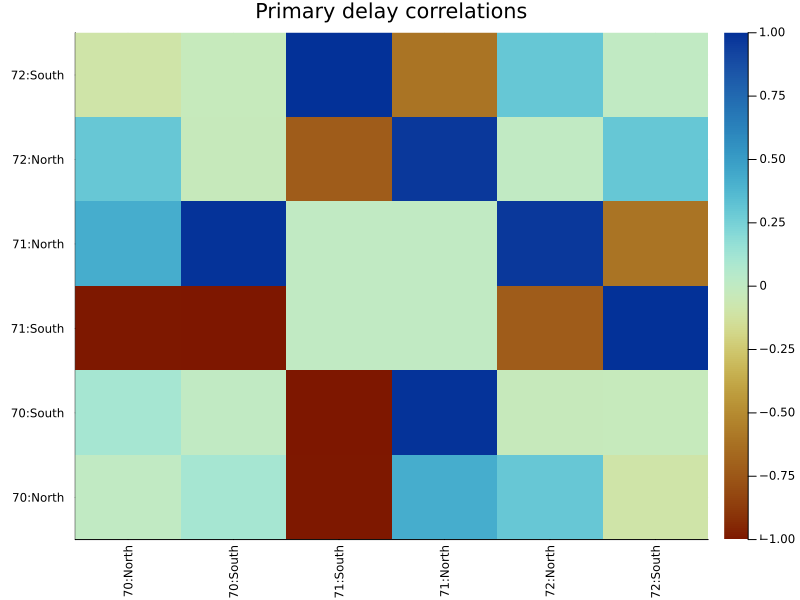

In [64]:
ind = 4
# custom_indices = .!isnothing.(indexin(names(cor_df[:, Not(:planned_start_hour)]), ["6:South", "6:North", "75:South", "75:North"]))
# custom_indices = .!isnothing.(indexin(names(cor_df[:, Not(:planned_start_hour)]), ["6:South", "6:North", "30:South", "30:North", "31:South", "31:North"]))
# custom_indices = .!isnothing.(indexin(names(cor_df[:, Not(:planned_start_hour)]), ["3:Clockwise", "3:Counterclockwise", "10:Clockwise", "10:Counterclockwise"]))
# custom_indices = .!isnothing.(indexin(names(cor_df[:, Not(:planned_start_hour)]), ["4:East", "4:West", "14:East", "14:West", "15:East", "15:West"]))
# custom_indices = .!isnothing.(indexin(names(cor_df[:, Not(:planned_start_hour)]), ["2:East", "2:West", "5:East", "5:West"]))
custom_indices = .!isnothing.(indexin(names(cor_df[:, Not(:planned_start_hour)]), ["70:South", "70:North", "71:South", "71:North", "72:South", "72:North"]))
# custom_indices = .!isnothing.(indexin(names(cor_df[:, Not(:planned_start_hour)]), ["2", "3", "5", "8", "10"]))
# custom_indices = .!isnothing.(indexin(names(cor_df[:, Not(:planned_start_hour)]), ["54", "55"]))
# custom_indices = .!isnothing.(indexin(names(cor_df[:, Not(:planned_start_hour)]), ["4", "14", "15"]))
# custom_indices = .!isnothing.(indexin(names(cor_df[:, Not(:planned_start_hour)]), ["70", "71", "72"]))

corr_heatmap = heatmap(
    # reordered_corr_matrix,
    # corr_matrix[vcat(cluster_indices...), vcat(cluster_indices...)],
    # corr_matrix[cluster_indices[ind], cluster_indices[ind]],
    corr_matrix[custom_indices, custom_indices],
    c=:roma,
    # xticks=(1:size(cluster_order,1), names(cor_df[:, Not(:planned_start_hour)])[cluster_order]),
    # xticks=(1:size(cluster_indices[ind],1), names(cor_df[:, Not(:planned_start_hour, :direction)])[cluster_indices[ind]]),
    # xticks=(1:size(vcat(cluster_indices...),1), names(cor_df[:, Not(:planned_start_hour)])[vcat(cluster_indices...)]),
    xticks=(1:size(custom_indices,1), names(cor_df[:, Not(:planned_start_hour)])[custom_indices]),
    xrot=90,
    # yticks=(1:size(cluster_order,1), names(cor_df[:, Not(:planned_start_hour)])[cluster_order]),
    # yticks=(1:size(cluster_indices[ind],1), names(cor_df[:, Not(:planned_start_hour, :direction)])[cluster_indices[ind]]),
    # yticks=(1:size(vcat(cluster_indices...),1), names(cor_df[:, Not(:planned_start_hour)])[vcat(cluster_indices...)]),
    yticks=(1:size(custom_indices,1), names(cor_df[:, Not(:planned_start_hour)])[custom_indices]),
    title="Primary delay correlations",
    size=(800, 600),
    clims=(-1,1)
)
# savefig(corr_heatmap, "imgs\\victoria_4-14-15_corr.png")

In [52]:
route_tuples = findall((corr_matrix .< 1) .& (corr_matrix .> 0.90))
for (r1, r2) in Tuple.(route_tuples)
    println(names(cor_df)[r1+2], " ", names(cor_df)[r2+2])
end

82 1
43 3
43 4
52 9
61 9
95 9
65 11
63 14
95 17
43 21
82 21
47 22
63 24
65 24
63 25
65 26
64 32
60 35
82 35
85 35
63 39
3 43
4 43
21 43
85 43
82 46
22 47
56 48
65 48
82 48
88 51
9 52
65 52
82 52
82 53
48 56
64 58
82 58
82 59
35 60
9 61
14 63
24 63
25 63
39 63
72 63
81 63
32 64
58 64
87 64
11 65
24 65
26 65
48 65
52 65
75 65
72 71
63 72
71 72
65 75
63 81
1 82
21 82
35 82
46 82
48 82
52 82
53 82
58 82
59 82
35 85
43 85
64 87
51 88
9 95
17 95


In [46]:
weekday_adj = weekday_df

for trip in eachrow(weekday_adj)
    for row in eachrow(combined_df)
        if trip.route == row.route && trip.planned_start_hour == row.planned_start_hour && trip.direction == row.direction
            trip.primary_delay_seconds += ceil(max(-row.primary_μ, 0))
        end
    end
end

In [17]:
nx = nanaimo_wkdy.primary_delay_seconds ./ 60
ny = nanaimo_wkdy.start_delay_seconds ./ 60
vx = victoria_wkdy.primary_delay_seconds ./ 60
vy = victoria_wkdy.start_delay_seconds ./ 60;

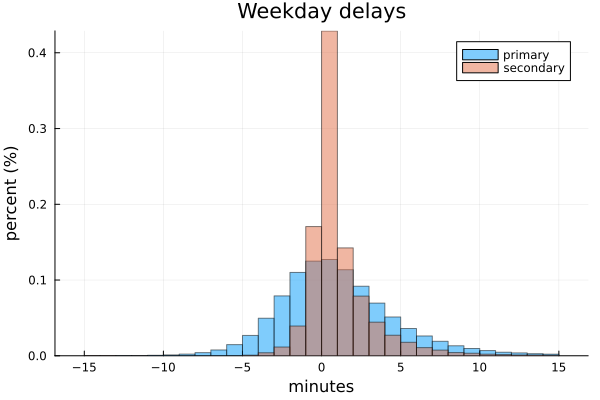

In [24]:
# nanaimo_hist = histogram(
#     [nx ny],
#     bins=range(-15, 15, length=31),
#     normalize=true,
#     label=["primary" "secondary"],
#     alpha=0.5,
#     xlabel="minutes",
#     ylabel="percent (%)",
#     title="Nanaimo weekday delays",
# )
victoria_hist = histogram(
    [vx vy],
    bins=range(-15, 15, length=31),
    normalize=true,
    label=["primary" "secondary"],
    alpha=0.5,
    xlabel="minutes",
    ylabel="percent (%)",
    title="Weekday delays",
)
# histplot = plot(nanaimo_hist, victoria_hist,  layout=(1, 2), link=:y, size=(750, 450))
# savefig(victoria_hist, "imgs\\weekday_delay_histogram_victoria.png")

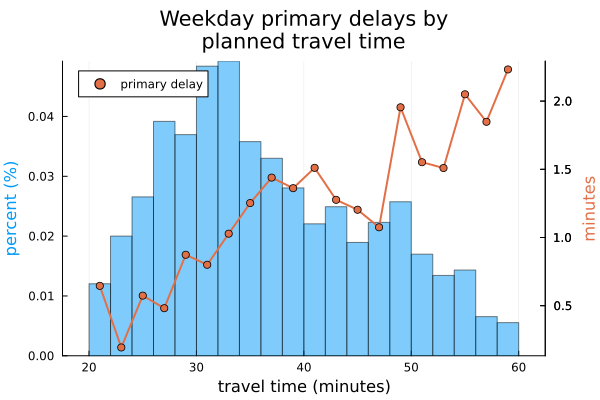

In [19]:
# travel_time_hist = histogram(
#     nanaimo_wkdy.planned_duration_seconds ./ 60,
#     bins=range(0, 80, length=21),
#     normalize=true,
#     label="nanaimo",
#     alpha=0.5,
#     xlabel="minutes",
#     ylabel="percent (%)",
#     title="Weekday travel times",
# )
planned_durations = victoria_wkdy.planned_duration_seconds ./ 60
primary_delays = victoria_wkdy.primary_delay_seconds ./ 60

bin_edges = range(20, 60, length=21)
bin_centers = collect(midpoints(bin_edges))

bin_indices = fit(Histogram, planned_durations, bin_edges, closed=:left).weights
binned_delay_means = [mean(primary_delays[planned_durations .>= bin_edges[i] .&& planned_durations .< bin_edges[i+1]]) for i in 1:length(bin_edges)-1]

travel_time_hist = histogram(
    planned_durations,
    bins=bin_edges,
    normalize=true,
    label="",
    xlabel="travel time (minutes)",
    ylabel="percent (%)",
    yguidefontcolor=palette(:default)[1],
    alpha=0.5,
    title="Weekday primary delays by\nplanned travel time\n",
)
plot!(
    twinx(),
    bin_centers,
    binned_delay_means,
    seriestype=:line,
    label="",
    color=palette(:default)[2],
    yguidefontcolor=palette(:default)[2],
    lw=2,
    ylabel="minutes"
)
plot!(
    twinx(),
    bin_centers,
    binned_delay_means,
    seriestype=:scatter,
    label="primary delay",
    color=palette(:default)[2],
    lw=2,
    legend=:topleft
)
# savefig(travel_time_hist, "imgs\\weekday_travel_time_histogram_victoria.png")

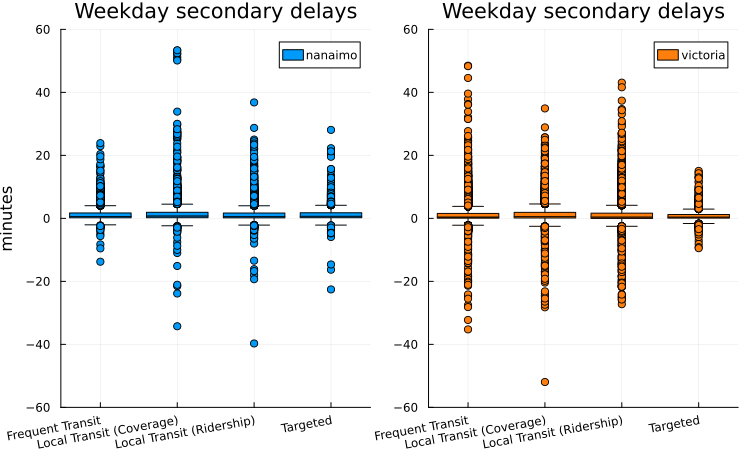

In [139]:
nanaimo_box = @df nanaimo_wkdy[.!ismissing.(nanaimo_wkdy.route_class), :] boxplot(
    :route_class,
    :start_delay_seconds ./ 60,
    ylims=(-60, 60),
    label="nanaimo",
    ylabel="minutes",
    xrotation=10,
)
victoria_box = @df victoria_wkdy[(.!ismissing.(victoria_wkdy.route_class)) .& (victoria_wkdy.route_class .!= "Rapid Transit"), :] boxplot(
    :route_class,
    :start_delay_seconds ./ 60,
    ylims=(-60, 60),
    color=palette(:tab10)[2],
    label="victoria",
    xrotation=10,
)
plotbox = plot(nanaimo_box, victoria_box,  layout=(1, 2), link=:y, size=(750, 450), title="Weekday secondary delays")
# savefig(plotbox, "imgs\\weekday_sdelay_box.png")

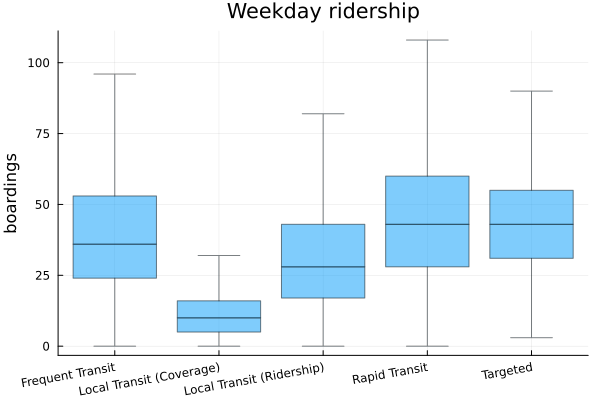

In [55]:
# ridership_violin = @df nanaimo_wkdy[.!ismissing.(nanaimo_wkdy.route_class), :] violin(
#     :route_class,
#     :total_boardings,
#     side=:left,
#     label="nanaimo",
#     ylabel="boardings",
#     xrotation=10,
#     title="Weekday ridership"
# )
# @df victoria_wkdy[(.!ismissing.(victoria_wkdy.route_class)) .& (victoria_wkdy.route_class .!= "Rapid Transit"), :] violin(
ridership_boxplot = @df victoria_wkdy[.!ismissing.(victoria_wkdy.route_class), :] boxplot(
    :route_class,
    :total_boardings,
    # side=:right,
    outliers=false,
    alpha=0.5,
    label="",
    ylabel="boardings",
    xrotation=10,
    title="Weekday ridership"
)
# savefig(ridership_boxplot, "imgs\\weekday_ridership_boxplot_victoria.png")

In [22]:
victoria_grouped = DataFrames.groupby(victoria_wkdy, :planned_start_hour)

q25 = x -> quantile(x, 0.25)
q50 = x -> quantile(x, 0.5)
q75 = x -> quantile(x, 0.75)

victoria_combined = combine(
    victoria_grouped,
    :total_boardings => mean => :ridership_μ,
    :total_boardings => std => :ridership_σ,
    :total_boardings => q25 => :ridership_q25,
    :total_boardings => q50 => :ridership_q50,
    :total_boardings => q75 => :ridership_q75,
    :passenger_delay_seconds => mean => :passenger_delay_μ,
    :passenger_delay_seconds => std => :passenger_delay_σ,
    :passenger_delay_seconds => q25 => :passenger_delay_q25,
    :passenger_delay_seconds => q50 => :passenger_delay_q50,
    :passenger_delay_seconds => q75 => :passenger_delay_q75,
    :end_delay_seconds => mean => :end_delay_μ,
    :end_delay_seconds => std => :end_delay_σ,
    :end_delay_seconds => q25 => :end_delay_q25,
    :end_delay_seconds => q50 => :end_delay_q50,
    :end_delay_seconds => q75 => :end_delay_q75,
    :primary_delay_seconds => mean => :primary_μ,
    :start_delay_seconds => mean => :secondary_μ,
    :primary_delay_seconds => std => :primary_σ,
    :start_delay_seconds => std => :secondary_σ,
    :primary_delay_seconds => q25 => :primary_q25,
    :primary_delay_seconds => q50 => :primary_q50,
    :primary_delay_seconds => q75 => :primary_q75,
    :start_delay_seconds => q25 => :secondary_q25,
    :start_delay_seconds => q50 => :secondary_q50,
    :start_delay_seconds => q75 => :secondary_q75
);

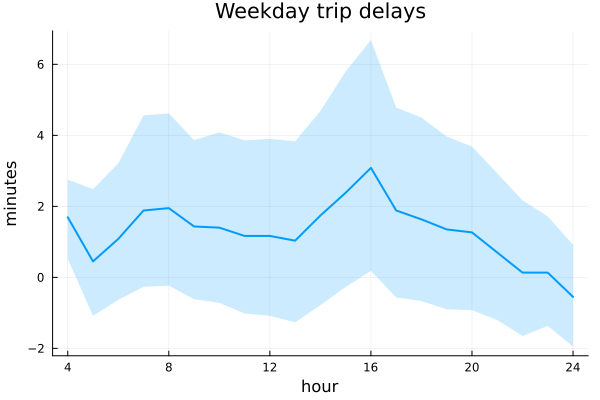

In [26]:
# hourly_delay_plot = @df nanaimo_combined plot(
#     :planned_start_hour,
#     :primary_μ .* :ridership_μ ./ 60,
#     ribbon=:primary_σ .* :ridership_σ ./ 60,
#     label="nanaimo",
#     lw=2,
#     fillalpha=0.2,
#     xlabel="hour",
#     ylabel="passenger ⋅ minutes",
#     title="Weekday passenger delays"
# )

hourly_delay_plot = @df victoria_combined plot(
    :planned_start_hour,
    :end_delay_q50 ./ 60,
    # :passenger_delay_q50 ./ 60,
    # fillrange=(:passenger_delay_q25 ./ 60, :passenger_delay_q75 ./ 60),
    fillrange=(:end_delay_q25 ./ 60, :end_delay_q75 ./ 60),
    label="",
    lw=2,
    fillalpha=0.2,
    xlabel="hour",
    xticks=[4, 8, 12, 16, 20, 24],
    ylabel="minutes",
    title="Weekday trip delays"
)
# savefig(hourly_delay_plot, "imgs\\weekday_passenger_delays_victoria.png")